# Capstone #3: Telco Customer Churn

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,cross_validate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore') 

---
# Business Problem and Data Understanding

**Context:**
The dataset represents customer profiles who have left the telco company. A churn in telco and other subscription-based services means a situation when the customer leaves the service provider. 

**Features:**
- Dependents: Whether the customer has dependents or not.
- Tenure: Number of months the customer has stayed with the company.
- OnlineSecurity: Whether the customer has online security or not.
- OnlineBackup: Whether the customer has online backup or not.
- InternetService: Whether the client is subscribed to Internet service.
- DeviceProtection: Whether the client has device protection or not.
- TechSupport: Whether the client has tech support or not 
- Contract: Type of contract according to duration.
- PaperlessBilling: Bills issued in paperless form.
- MonthlyCharges: Amount of charge for service on monthly bases.
- Churn: Whether the customer churns or not.

**Target:**

0 : Customer not churns

1 : Customer churns

**Background**

In the telecommunications industry, customer churn is one of the most significant challenges faced by companies. Churn can result in substantial losses for the organization, as departing customers not only discontinue their service usage but also potentially damage the company's reputation and reduce revenue.

In this context, a telecommunications company possesses a dataset that records the profiles of customers who have left the company. This dataset contains information about customer characteristics, such as whether they have dependents, their tenure as customers, and whether they have subscribed to online security, online backup, internet service, device protection, and technical support, as well as the type of contract they hold.

**Problem Statement**

Based on the available dataset, the telecommunications company aims to **predict which customers are likely to churn** (discontinue their service usage) in the future. By doing so, the company can take proactive measures to prevent customer loss and enhance customer loyalty.

**Confusion Matrix**

- True Negative (TN) = Customers who were predicted not to churn and actually did not churn
- True Positive (TP) = Customers who were predicted to churn and actually churned
- False Negative (FN) = Customers who were predicted not to churn but actually churned (Type II error)
- False Positive (FP) = Customers who were predicted to churn but did not actually churn (Type I error) 

False Positive (FP) occurs when the prediction model incorrectly predicts that a customer will churn, resulting in unnecessary expenses and potential damage to customer relationships.

False Negative (FN) occurs when the prediction model incorrectly predicts that a customer will not churn, resulting in the loss of that customer and missed opportunities to increase loyalty and retention.

In the context of churn prediction, **False Negative (FN) is more important than False Positive (FP)**. This is because False Negative can result in the loss of customers who actually churn, leading to greater losses for the company. Therefore, reducing the number of False Negative (FN) might be seen as more important.

**Metric Evaluation**: Recall will be used as the primary evaluation metric to compare and select the best model for this project, as our main focus is on minimizing False Negatives (FN) to ensure accurate churn prediction.

In [43]:
# Load dataset

df_telco = pd.read_csv('data_telco_customer_churn.csv')
df_telco.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


In [44]:
df_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4930 non-null   object 
 1   tenure            4930 non-null   int64  
 2   OnlineSecurity    4930 non-null   object 
 3   OnlineBackup      4930 non-null   object 
 4   InternetService   4930 non-null   object 
 5   DeviceProtection  4930 non-null   object 
 6   TechSupport       4930 non-null   object 
 7   Contract          4930 non-null   object 
 8   PaperlessBilling  4930 non-null   object 
 9   MonthlyCharges    4930 non-null   float64
 10  Churn             4930 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 423.8+ KB


In [45]:
# Data missing value

df_telco.isna().sum()

Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
InternetService     0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
MonthlyCharges      0
Churn               0
dtype: int64

In [46]:
# Numerical data distribution

df_telco.describe()

,tenure,MonthlyCharges
count,4930.000000,4930.000000
mean,32.401217,64.883032
std,24.501193,29.923960
min,0.000000,18.800000
25%,9.000000,37.050000
50%,29.000000,70.350000
75%,55.000000,89.850000
max,72.000000,118.650000


In [47]:
# Categorical data distribution

df_telco.describe(include=object)

,Dependents,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,Churn
count,4930,4930,4930,4930,4930,4930,4930,4930,4930
unique,2,3,3,3,3,3,3,2,2
top,No,No,No,Fiber optic,No,No,Month-to-month,Yes,No
freq,3446,2445,2172,2172,2186,2467,2721,2957,3614


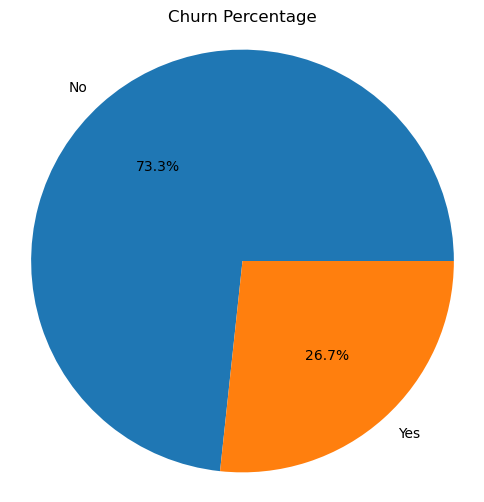

In [48]:
churn_count = df_telco['Churn'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    churn_count,
    labels=churn_count.index,
    autopct='%1.1f%%'
)
plt.title('Churn Percentage')
plt.axis('equal');

Summary:
- The dataset consists of 11 columns and 4930 rows.
- The dataset lacks a unique ID column, making it impossible to detect duplicate data.
- There are no missing values in the dataset.
- Most of the data is categorical (nominal) with a small number of unique values (2 or 3).
- The target variable is imbalanced, so a resampling method will be applied to ensure a balanced dataset, which may improve the reliability of the model.

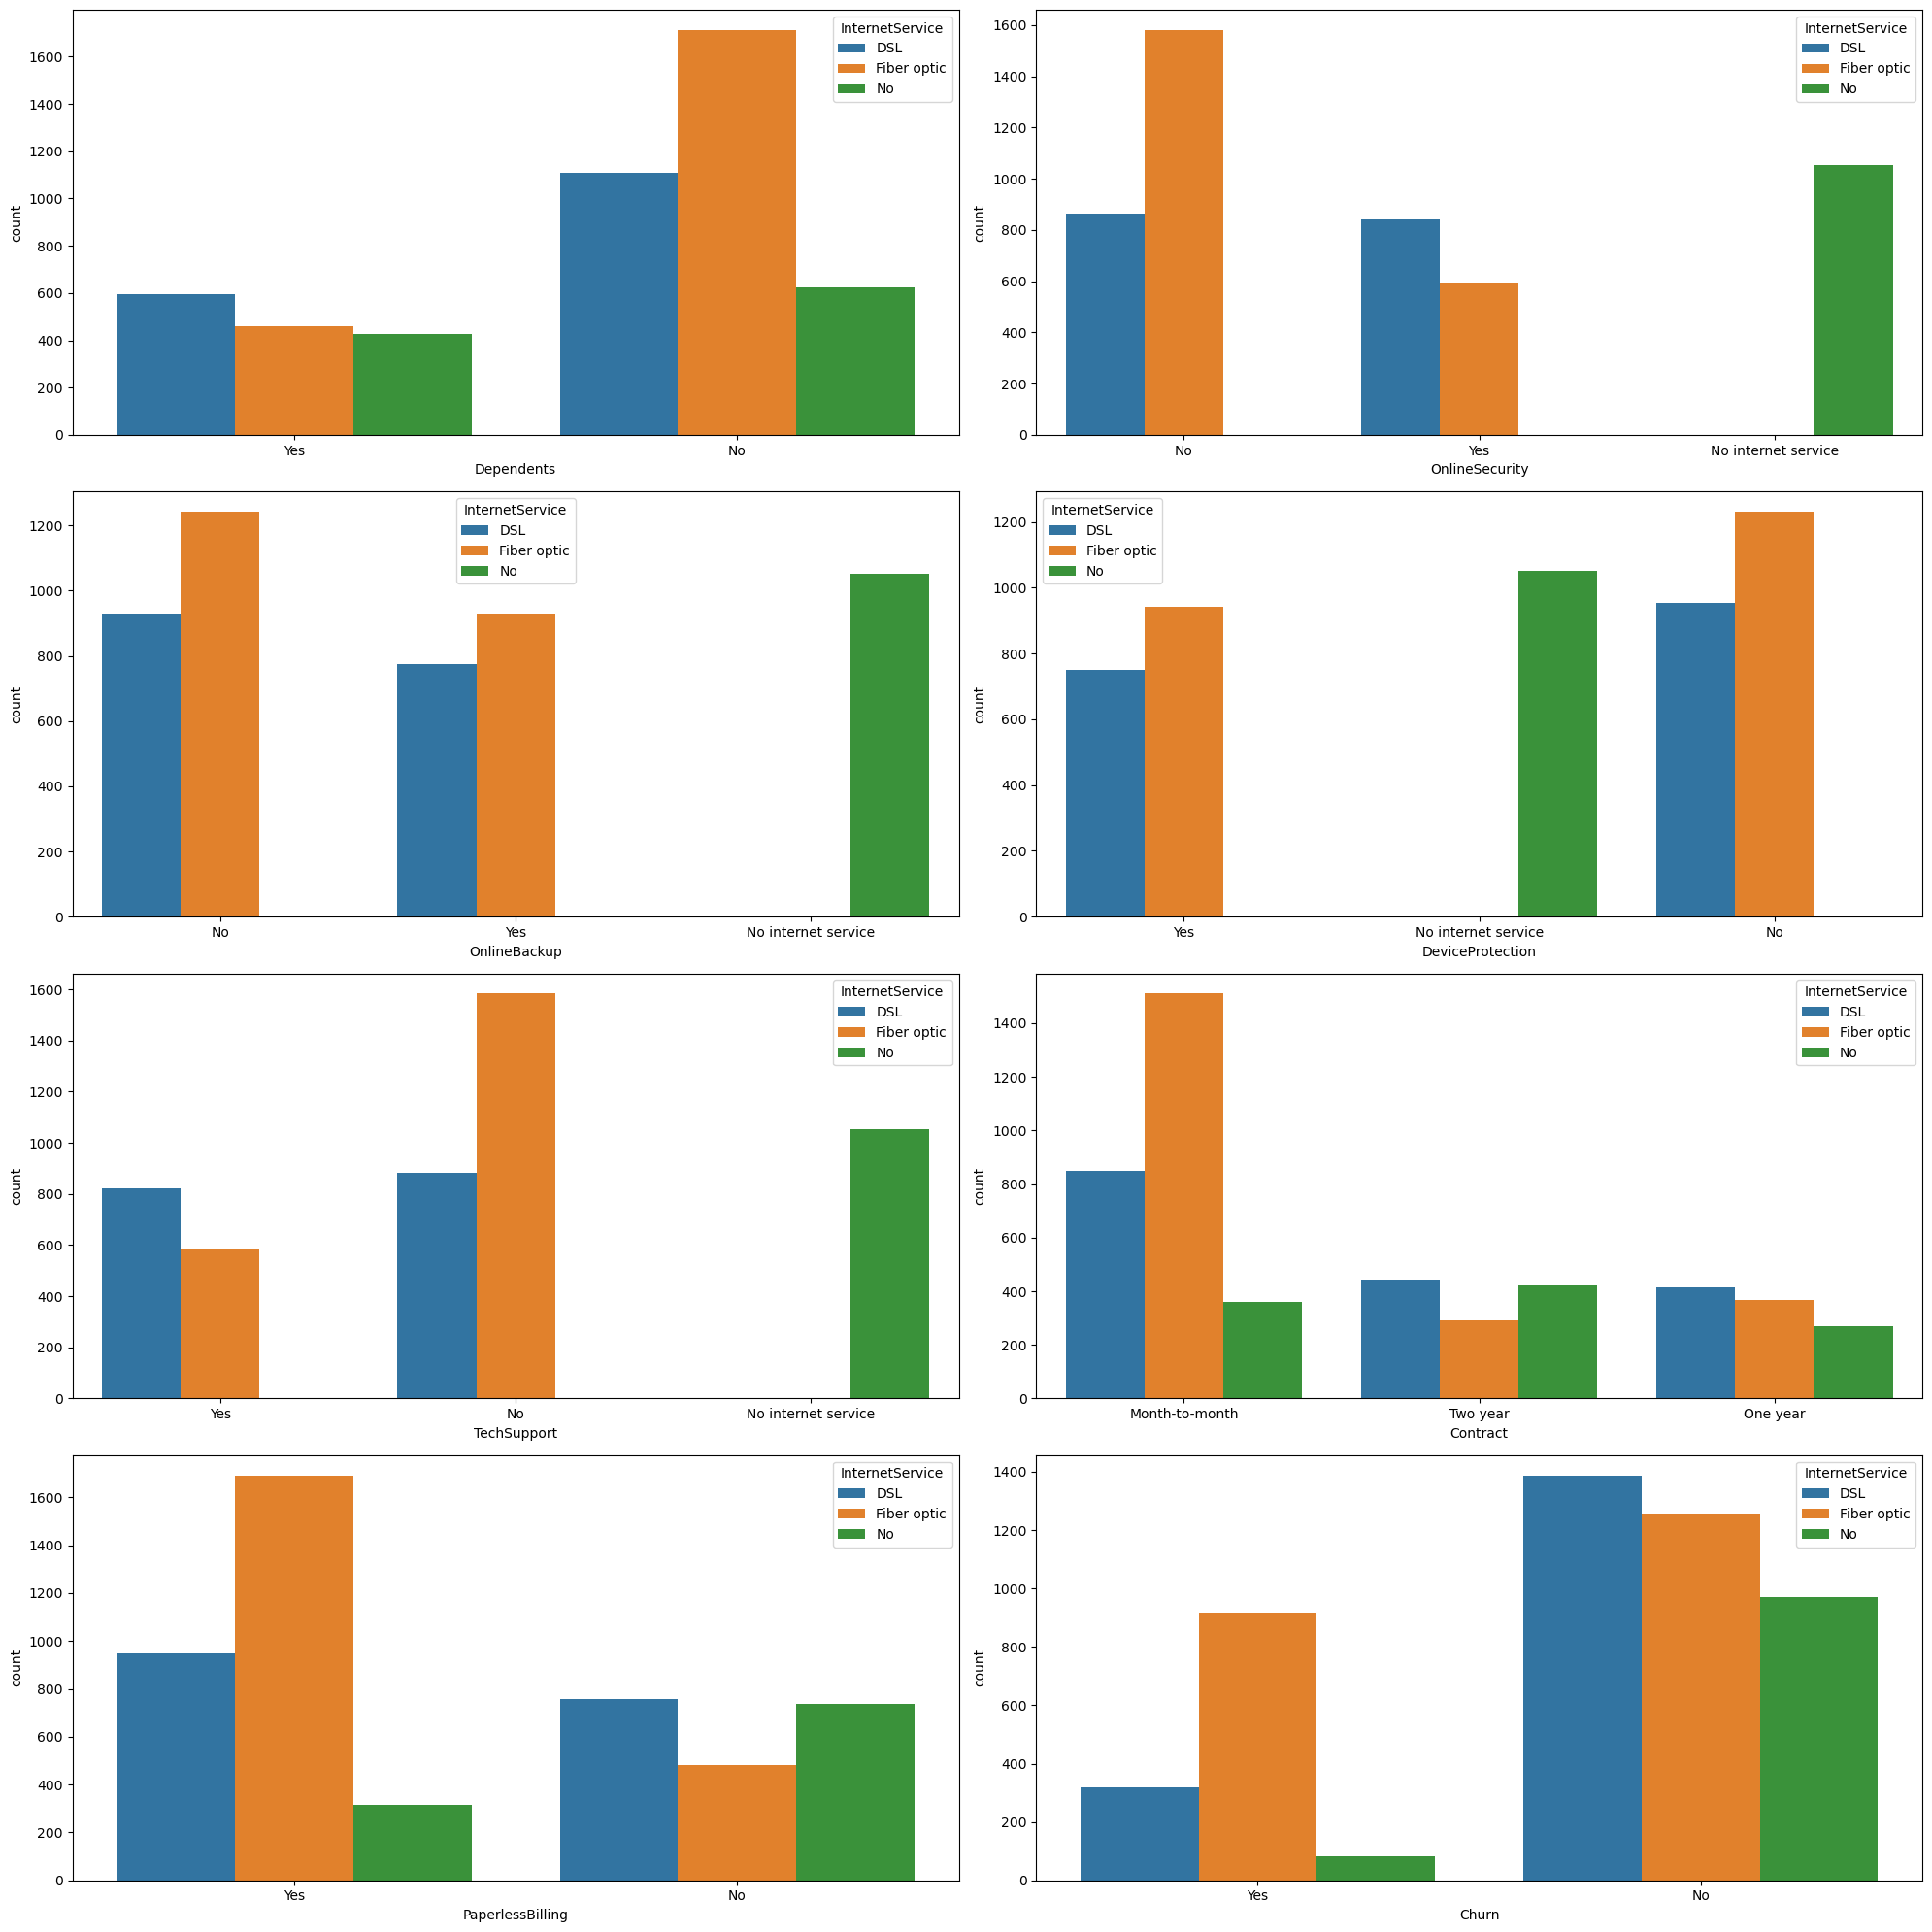

In [49]:
# Checking no internet service data

count = 0
fig = plt.figure(figsize=(20,20))

for i in df_telco.drop(columns=['InternetService','tenure','MonthlyCharges']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    sns.countplot(data = df_telco, x = i, hue = 'InternetService')
    fig.tight_layout()

plt.show()

Based on the image above, customers who do not purchase internet services are categorized as having "no internet service" in other datasets. No online service means the customer didn't use (layanan internet) from this company, so the services is not relevant.

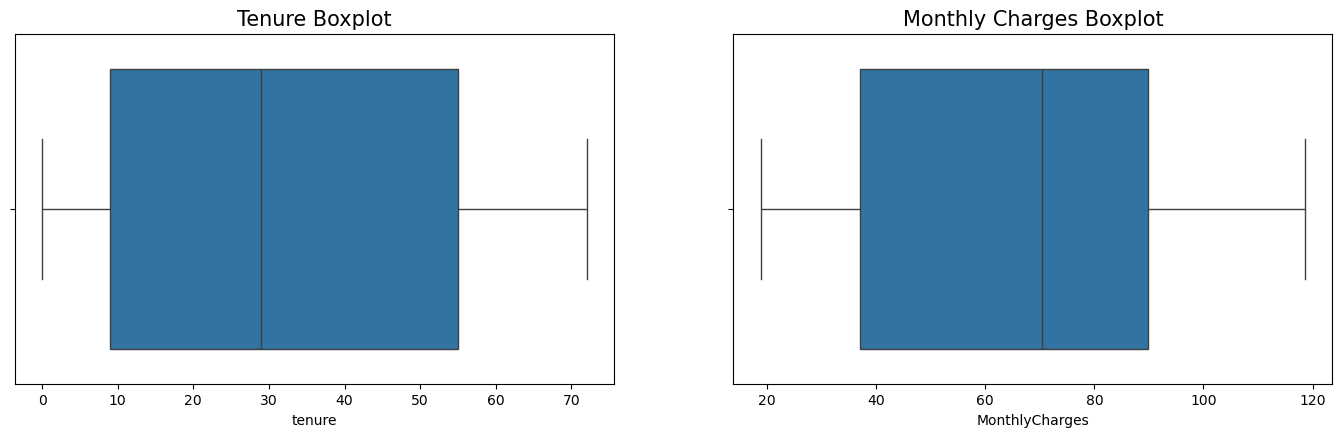

In [50]:
# Numerical Data Outlier

plt.figure(figsize=(17,10))

plt.subplot(221)
sns.boxplot(data = df_telco, x = 'tenure')
plt.title('Tenure Boxplot',fontsize=15)

plt.subplot(222)
sns.boxplot(data=df_telco, x ='MonthlyCharges')
plt.title('Monthly Charges Boxplot',fontsize=15)

plt.show()

As we can see from the boxplot distribution above, there's no outlier data in numerical data.

---
# EDA

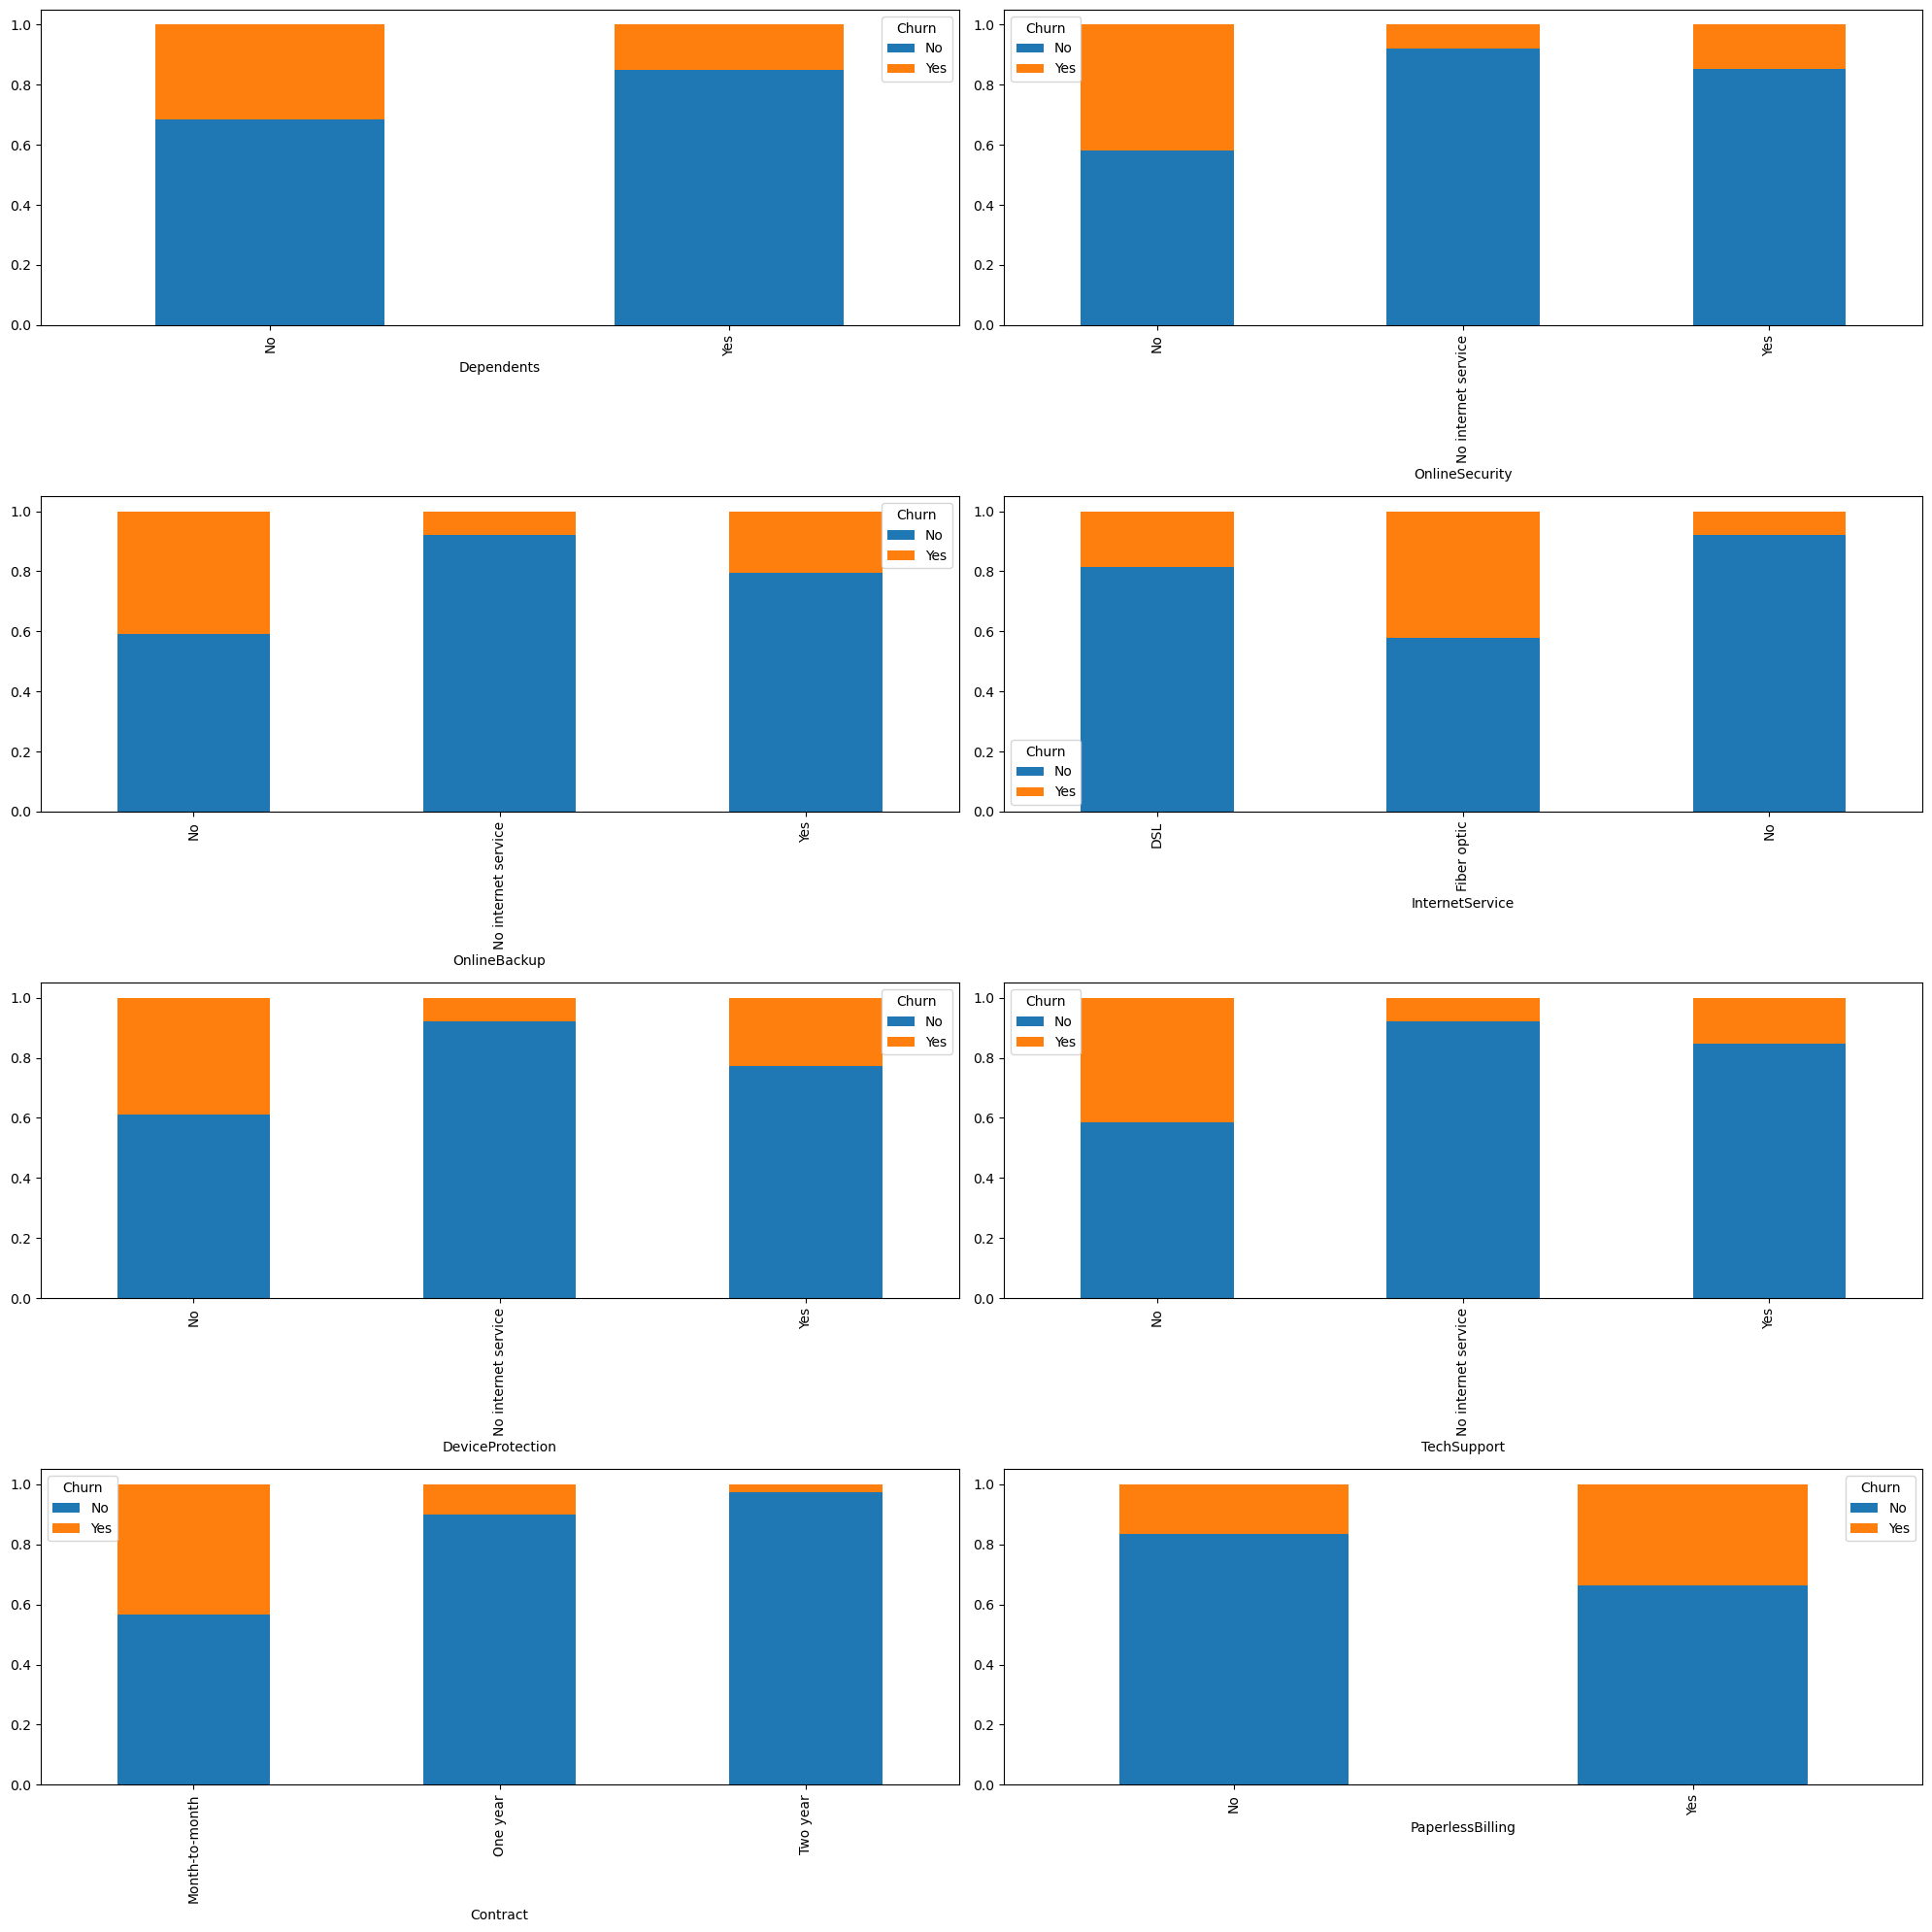

In [51]:
# Categorical Data

count = 0
fig = plt.figure(figsize=(20,20))

for i in df_telco.drop(columns=['Churn','tenure','MonthlyCharges']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    pd.crosstab(df_telco[i],df_telco['Churn'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

Based on the figure above, 
- Customers without dependents have a higher churn risk.
- Internet customers without online security have a higher churn risk.
- Internet customers without online backup have a higher churn risk.
- Fiber optic internet customers have a higher churn risk.
- Internet customers without device protection have a higher churn risk.
- Internet customers without tech support have a higher churn risk.
- Month-to-month contract customers have a higher churn risk.
- Paperless billing customers have a higher churn risk.

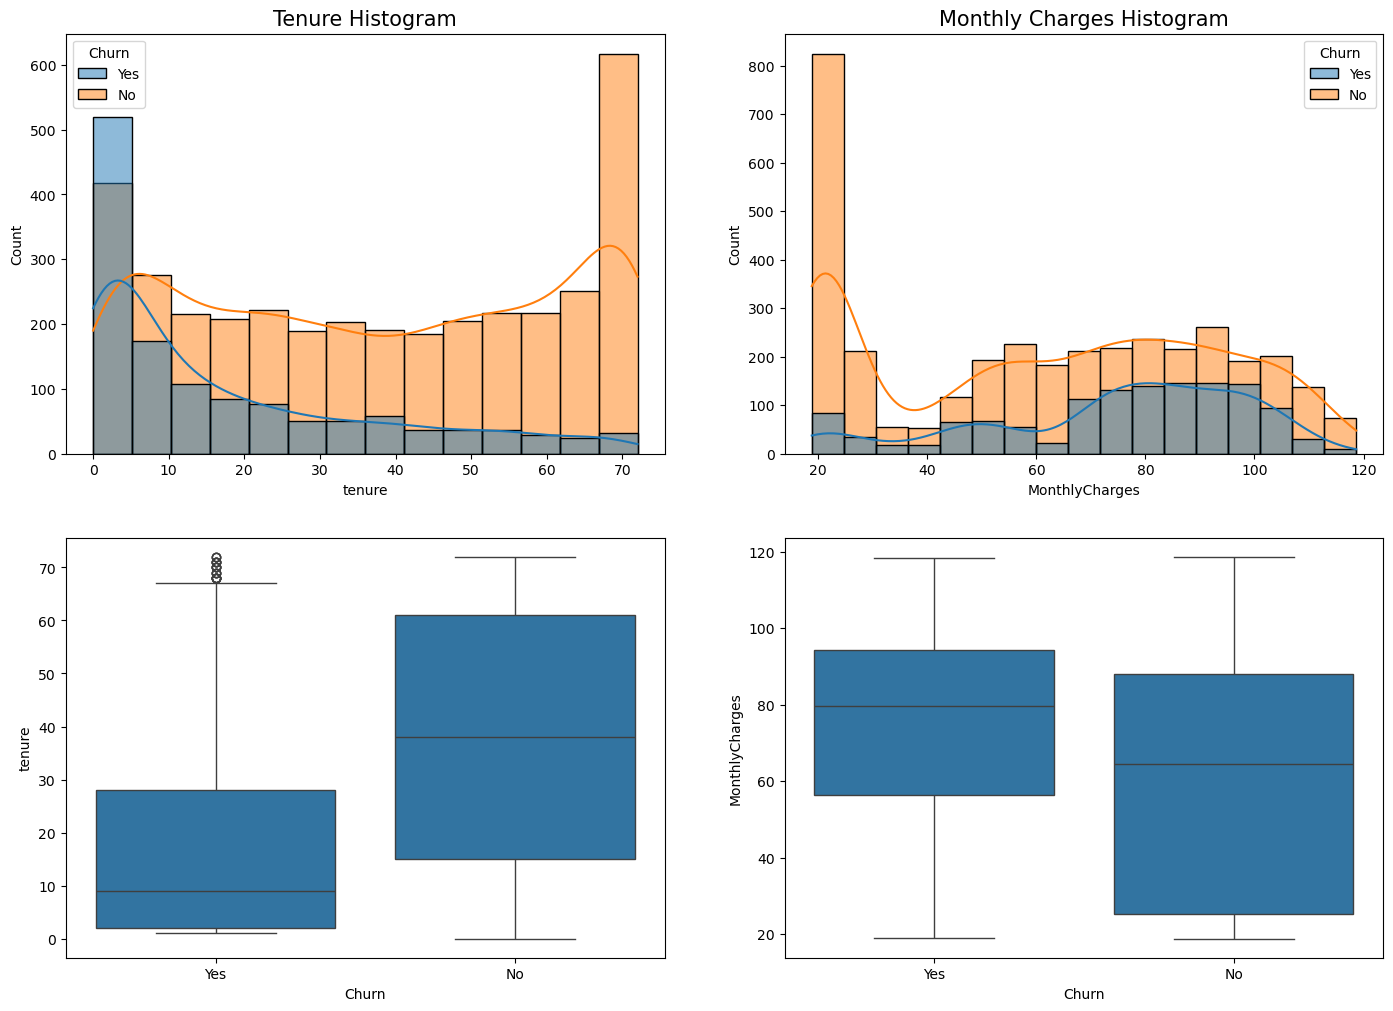

In [52]:
# Numerical Data

plt.figure(figsize=(17,12))

plt.subplot(221)
sns.histplot(data=df_telco,x='tenure',hue='Churn',kde=True)
plt.title('Tenure Histogram',fontsize=15)

plt.subplot(222)
sns.histplot(data=df_telco ,x='MonthlyCharges',hue='Churn',kde=True)
plt.title('Monthly Charges Histogram',fontsize=15)

plt.subplot(223)
sns.boxplot(data=df_telco ,y='tenure', x='Churn')

plt.subplot(224)
sns.boxplot(data=df_telco ,y='MonthlyCharges', x='Churn')
plt.show()

Based on the histogram and boxplot above, customers with shorter tenure are more likely to churn and higher monthly charges increase the risk of customer churn.


---
# Data Preparation

## Feature Engineering

- Label encoding for Yes/No column: 'Dependents', 'PaperlessBilling'
- Encoding for all the categorical column, except label encoding column, using One Hot Encoding because the small unique values and there's no ordinal data.
- Scaling for all numerical column using MinMaxScaler to change the range from 0 to 1.

In [53]:
# Label encoding

df_telco['Dependents'] = df_telco['Dependents'].replace({'Yes': 1, 'No': 0})
df_telco['PaperlessBilling'] = df_telco['PaperlessBilling'].replace({'Yes': 1, 'No': 0})

In [54]:
# Column grouping

ohe_cols = ['OnlineSecurity', 'OnlineBackup', 'InternetService', 'DeviceProtection', 'TechSupport', 'Contract']
numerical_cols = ['tenure', 'MonthlyCharges']

In [55]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(), ohe_cols),
    ('scaling', MinMaxScaler(), numerical_cols)
], remainder='passthrough')

## Data Splitting

We want to know if the customer will churn or not with 'Churn" column as the target.

In [56]:
X = df_telco.drop(columns='Churn')
y = df_telco['Churn'].replace({'Yes': 1, 'No': 0})

In [57]:
X_train,X_test,y_train,y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 1)

In [58]:
X_scaled = pd.DataFrame(transformer.fit_transform(X_train),columns=transformer.get_feature_names_out())
X_scaled.head()

,onehot__OnlineSecurity_No,onehot__OnlineSecurity_No internet service,onehot__OnlineSecurity_Yes,onehot__OnlineBackup_No,onehot__OnlineBackup_No internet service,onehot__OnlineBackup_Yes,onehot__InternetService_DSL,onehot__InternetService_Fiber optic,onehot__InternetService_No,onehot__DeviceProtection_No,...,onehot__TechSupport_No,onehot__TechSupport_No internet service,onehot__TechSupport_Yes,onehot__Contract_Month-to-month,onehot__Contract_One year,onehot__Contract_Two year,scaling__tenure,scaling__MonthlyCharges,remainder__Dependents,remainder__PaperlessBilling
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.125000,0.517777,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.000000,0.586380,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.625000,0.548322,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.444444,0.723585,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.972222,0.842764,0.0,1.0


---
# Modelling and Evaluation Model

Classification Machine Learning Model in scikit-learn that we will test:
- Logistic Regression
- Decision Trees
- Random Forest
- Support Vector Classifier (SVC)
- K-Nearest Neighbors (KNN)
- XGBoost Classifier

In [59]:
logreg = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
svc = SVC(probability=True)
knn = KNeighborsClassifier()
xgb = XGBClassifier()
gboost = GradientBoostingClassifier()

## Model Benchmarking: K-Fold

In [60]:
models = [logreg,dt,rf,svc,knn,xgb,gboost]

# A dictionary containing metrics used
metrics = {'balanced_accuracy': 'balanced_accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'}

accuracy_arr = []
precision_arr = []
recall_arr = []
score_f1_arr = []

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_validate(estimator,X_train,y_train,cv=skfold,scoring=metrics)
    accuracy_arr.append(model_cv['test_balanced_accuracy'].mean())
    precision_arr.append(model_cv['test_precision'].mean())
    recall_arr.append(model_cv['test_recall'].mean())
    score_f1_arr.append(model_cv['test_f1'].mean())
    
pd.DataFrame({'model':['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVC', 'KNN', 'XGBoost', 'Gradient Boost'],
            'accuracy':accuracy_arr,
            'precision':precision_arr,
            'recall':recall_arr,
            'f1 score':score_f1_arr}).set_index('model').sort_values(by='recall',ascending=False)

,accuracy,precision,recall,f1 score
model,,,,
XGBoost,0.707771,0.626179,0.532796,0.574893
Gradient Boost,0.714855,0.661126,0.528987,0.587464
Logistic Regression,0.709014,0.637820,0.528025,0.577414
Decision Tree,0.660678,0.504178,0.500528,0.501977
KNN,0.678959,0.581403,0.486251,0.529071
Random Forest,0.681056,0.599697,0.478682,0.531951
SVC,0.682478,0.650048,0.454891,0.534269


### Model Benchmarking : Test Data

In [61]:
models = [logreg,dt,rf,svc,knn,xgb,gboost]

accuracy_arr = []
precision_arr = []
recall_arr = []
score_f1_arr = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    X_train,X_test
    
    estimator.fit(X_train,y_train)
    return(estimator,estimator.predict(X_test),X_test)

for i,j in zip(models, ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVC', 'KNN', 'XGBoost', 'Gradient Boost']):
    estimator, y_pred, X_test = y_pred_func(i)
    accuracy_arr.append(accuracy_score(y_test, y_pred))
    precision_arr.append(precision_score(y_test, y_pred))
    recall_arr.append(recall_score(y_test, y_pred))
    score_f1_arr.append(f1_score(y_test, y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVC', 'KNN', 'XGBoost', 'Gradient Boost'],
            'accuracy':accuracy_arr,
            'precision':precision_arr,
            'recall':recall_arr,
            'f1 score':score_f1_arr}).set_index('model').sort_values(by='recall',ascending=False)

,accuracy,precision,recall,f1 score
model,,,,
Decision Tree,0.737323,0.507194,0.536122,0.521257
Logistic Regression,0.796146,0.655000,0.498099,0.565875
KNN,0.780933,0.612440,0.486692,0.542373
XGBoost,0.771805,0.587156,0.486692,0.532225
Random Forest,0.775862,0.599057,0.482890,0.534737
Gradient Boost,0.787018,0.634518,0.475285,0.543478
SVC,0.786004,0.649425,0.429658,0.517162


For benchmarking model, the best model for train data is XGBoost Classifier and the best model for test data is Decision Tree Classifier.

## Imbalance

In [62]:
# Train data
# Define imbalance treatment methods

ros = RandomOverSampler()
rus = RandomUnderSampler()
smote = SMOTE()
near = NearMiss()
smoteen = SMOTEENN()

models = {'Logistic Regression':logreg,
          'Decision Tree':dt,
          'Random Forest':rf,
          'SVC':svc,
          'KNN':knn,
          'XGBoost':xgb,
          'Gradient Boost':gboost}
resamples = {'Oversampling':ros,'Undersampling':rus,'SMOTE':smote,'NearMiss':near,'SMOTEENN':smoteen}

# A dictionary containing metrics used
metrics = {'balanced_accuracy': 'balanced_accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'}

accuracy_arr = []
precision_arr = []
recall_arr = []
score_f1_arr = []
list_model = []
list_resample = []

for name_resample,i in resamples.items():
    for name_model,j in models.items():
        skfold=StratifiedKFold(n_splits=5)
        estimator=Pipeline([
            ('preprocess',transformer),
            ('resample',i),
            ('model',j)])
        list_model.append(name_model)
        list_resample.append(name_resample)
        model_cv=cross_validate(estimator,X_train,y_train,cv=skfold,scoring=metrics)
        accuracy_arr.append(model_cv['test_balanced_accuracy'].mean())
        precision_arr.append(model_cv['test_precision'].mean())
        recall_arr.append(model_cv['test_recall'].mean())
        score_f1_arr.append(model_cv['test_f1'].mean())
    
pd.DataFrame({'model':list_model,
            'reample':list_resample,
            'accuracy':accuracy_arr,
            'precision':precision_arr,
            'recall':recall_arr,
            'f1 score':score_f1_arr}).set_index('model').sort_values(by='recall',ascending=False)

,reample,accuracy,precision,recall,f1 score
model,,,,,
Logistic Regression,SMOTEENN,0.756150,0.499956,0.806310,0.616958
Logistic Regression,Oversampling,0.760131,0.510951,0.798718,0.623102
Logistic Regression,Undersampling,0.758242,0.509949,0.794940,0.621072
Logistic Regression,SMOTE,0.760223,0.514331,0.793017,0.623903
Gradient Boost,Undersampling,0.756547,0.510138,0.790151,0.619702
SVC,Oversampling,0.751995,0.505474,0.783480,0.614423
SVC,Undersampling,0.748976,0.501567,0.781598,0.610658
SVC,SMOTE,0.751664,0.507262,0.779702,0.614393
SVC,SMOTEENN,0.747901,0.501143,0.778750,0.609564


In [63]:
# Predict Test Data

resamples = {'Oversampling':ros,'Undersampling':rus,'SMOTE':smote,'SMOTEENN':smoteen}

accuracy_arr = []
precision_arr = []
recall_arr = []
score_f1_arr = []
list_model = []
list_resample = []
conf_matrix = []

for name_resample,j in resamples.items():
    estimator=Pipeline([
        ('preprocess',transformer),
        ('resample',j),
        ('model',logreg)])
    X_train,X_test
    estimator.fit(X_train,y_train)
    y_pred = estimator.predict(X_test)
    accuracy_arr.append(accuracy_score(y_test, y_pred))
    precision_arr.append(precision_score(y_test, y_pred))
    recall_arr.append(recall_score(y_test, y_pred))
    score_f1_arr.append(f1_score(y_test, y_pred))
    conf_matrix.append(confusion_matrix(y_test, y_pred))

index_model = [f'Logistic Regression with {name_resample}' for name_resample in resamples.keys()]
df_model = pd.DataFrame({'model':index_model,
                        'accuracy':accuracy_arr,
                        'precision':precision_arr,
                        'recall':recall_arr,
                        'f1 score':score_f1_arr}).set_index('model').sort_values(by='recall',ascending=False)
df_model

,accuracy,precision,recall,f1 score
model,,,,
Logistic Regression with SMOTEENN,0.735294,0.502381,0.802281,0.617862
Logistic Regression with Oversampling,0.759635,0.533679,0.783270,0.634823
Logistic Regression with Undersampling,0.761663,0.536458,0.783270,0.636785
Logistic Regression with SMOTE,0.762677,0.538462,0.771863,0.634375


The Logistic Regression model with SMOOTEEN sampling achieves the best performance, with a slightly lower recall on the test data compared to the train data, indicating a well-balanced model that avoids both overfitting and underfitting.

In [64]:
metric_df = df_model.loc[['Logistic Regression with SMOTEENN']]
metric_df

,accuracy,precision,recall,f1 score
model,,,,
Logistic Regression with SMOTEENN,0.735294,0.502381,0.802281,0.617862


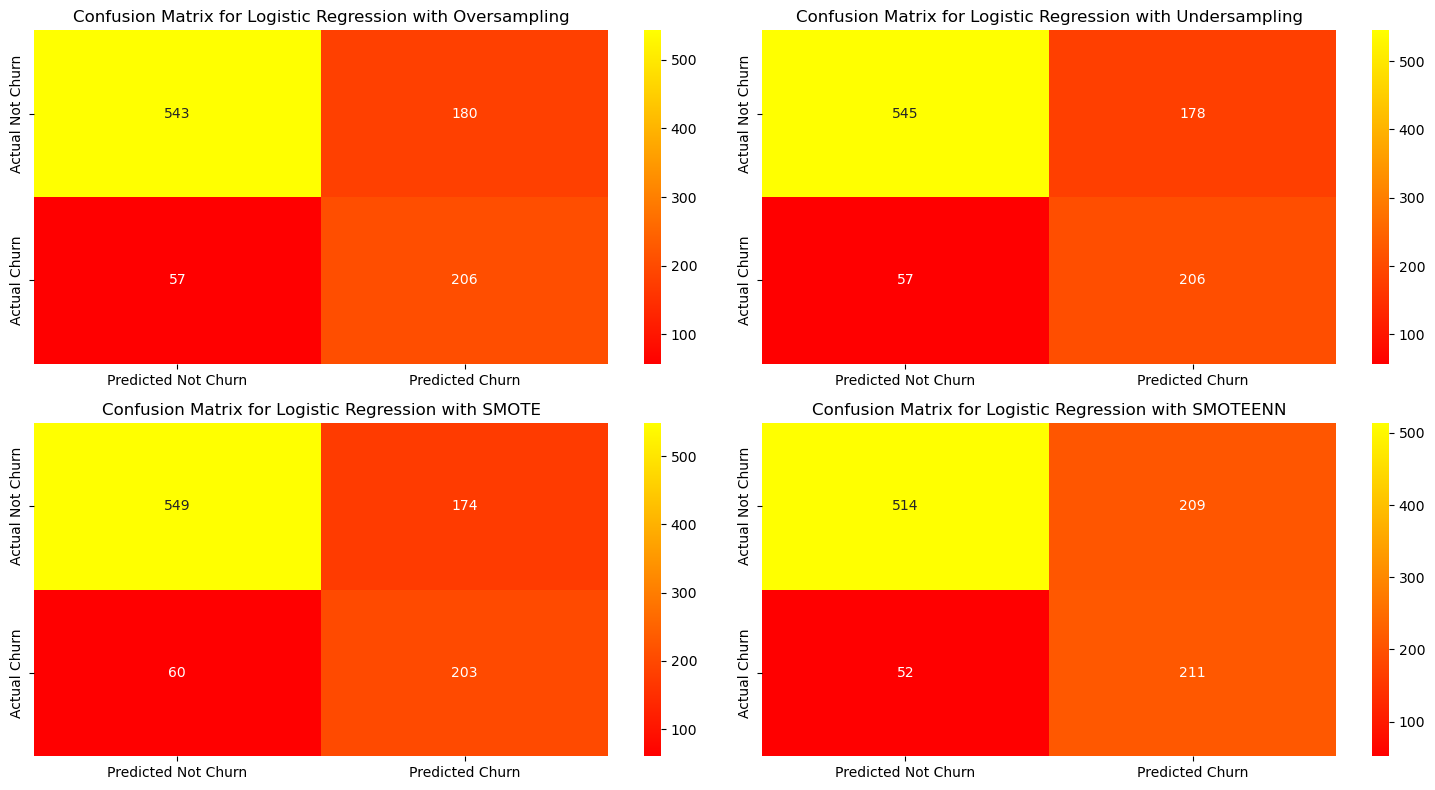

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

for i, (resample_name, _) in enumerate(resamples.items()):
    j = i // 2 
    k = i % 2
    sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='autumn',
                xticklabels=['Predicted Not Churn', 'Predicted Churn'],
                yticklabels=['Actual Not Churn', 'Actual Churn'], ax=axes[j][k])
    axes[j][k].set_title(f"Confusion Matrix for Logistic Regression with {resample_name}")

plt.tight_layout()
plt.show()

## Hyperparameter Tuning

source = https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Default parameter:
- Penalty = ’l2’
- C = 1.0
- Solver = ’lbfgs’
- Max_iter = 100

In [66]:
# logreg undersampling

hyperparam_space = {
    'model__penalty': [None, 'l2', 'l1', 'elastic-net'], 
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'saga', 'lbfgs'],
    'model__max_iter': [100, 500, 1000],
}

logreg = LogisticRegression()
smoteen = SMOTEENN()

pipe_model = Pipeline([
    ('prep', transformer),
    ('resampling', smoteen),
    ('model', logreg)
])

# Define Grid Search
gridsearch = GridSearchCV(
    estimator=pipe_model,
    param_grid=hyperparam_space,  
    cv=5,  
    scoring = 'recall',  
    n_jobs = -1 
)

gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'InternetService',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'Contract']),
                                                                        ('scaling',
                                                                         MinMaxScaler(),
                                                                         ['tenure',
                                                                          'MonthlyCharges'])])),
                                       ('resampling', SMOTEENN()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'model__max_iter': [100, 500, 1000],
                         'model__penalty': [None, 'l2', 'l1', 'elastic-net'],
                         'model__solver': ['liblinear', 'saga', 'lbfgs']},
             scoring='recall')

In [67]:
print('Best Hyperparameters: ', gridsearch.best_params_)
print('Best Score: ', gridsearch.best_score_)

Best Hyperparameters:  {'model__C': 0.01, 'model__max_iter': 1000, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best Score:  0.876560595802302


In [68]:
X_train

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges
4438,0,9,No,No,Fiber optic,No,No,Month-to-month,1,70.50
1213,0,72,No,Yes,DSL,Yes,Yes,Two year,0,77.35
4580,0,45,Yes,No,DSL,No,Yes,Two year,0,73.55
3524,0,32,No,No,Fiber optic,No,No,Month-to-month,0,91.05
2461,0,70,No,Yes,Fiber optic,Yes,No,Month-to-month,1,102.95
...,...,...,...,...,...,...,...,...,...,...
570,0,24,No,Yes,Fiber optic,Yes,No,Month-to-month,1,104.25
4608,0,37,Yes,Yes,DSL,Yes,Yes,One year,1,90.60
394,1,38,Yes,Yes,DSL,Yes,Yes,One year,0,74.05
835,0,48,No internet service,No internet service,No,No internet service,No internet service,One year,0,24.35


In [69]:
logreg_tuning = gridsearch.best_estimator_
logreg_tuning.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Contract']),
                                                 ('scaling', MinMaxScaler(),
                                                  ['tenure',
                                                   'MonthlyCharges'])])),
                ('resampling', SMOTEENN()),
                ('model',
                 LogisticRegression(C=0.01, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [70]:
accuracy_arr = []
precision_arr = []
recall_arr = []
score_f1_arr = []

# After Tuning
y_pred_tuned = logreg_tuning.predict(X_test)
accuracy_arr.append(accuracy_score(y_test, y_pred_tuned))
precision_arr.append(precision_score(y_test, y_pred_tuned))
recall_arr.append(recall_score(y_test, y_pred_tuned))
score_f1_arr.append(f1_score(y_test, y_pred_tuned))

metric_after_tuning = pd.DataFrame({'model':['Logistic Regression 1st Tuning'],
                                    'accuracy':accuracy_arr,
                                    'precision':precision_arr,
                                    'recall':recall_arr,
                                    'f1 score':score_f1_arr}).set_index('model')
metric_df = pd.concat([metric_df, metric_after_tuning])
metric_df

,accuracy,precision,recall,f1 score
model,,,,
Logistic Regression with SMOTEENN,0.735294,0.502381,0.802281,0.617862
Logistic Regression 1st Tuning,0.699797,0.466395,0.870722,0.607427


In [71]:
hyperparam_space = {
    'model__penalty': [None, 'l2', 'l1', 'elastic-net'], #
    'model__C': [0.001, 0.005, 0.01, 0.05, 0.1],
    'model__solver': ['liblinear', 'saga', 'lbfgs'],
    'model__max_iter': [150, 125, 100, 75, 50],
}

# Define Grid Search
gridsearch2 = GridSearchCV(
    estimator=logreg_tuning,
    param_grid=hyperparam_space,  # specifies the range of hyperparameter values to be explored in the grid search
    cv=5,   # specifies the number of folds to be used for cross-validation to evaluate the model
    scoring = 'recall',   # defines the metric used to evaluate the hyperparameter combinations and select the best model
    n_jobs = -1   # to speed up the process by utilizing multiple cores of the machine
)

gridsearch2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'InternetService',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'Contract']),
                                                                        ('scaling',
                                                                         MinMaxScaler(),
                                                                         ['tenure',
                                                                          'MonthlyCharges'])])),
                                       ('resampling', SMOTEENN()),
                                       ('model',
                                        LogisticRegression(C=0.01,
                                                           max_iter=1000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'model__C': [0.001, 0.005, 0.01, 0.05, 0.1],
                         'model__max_iter': [150, 125, 100, 75, 50],
                         'model__penalty': [None, 'l2', 'l1', 'elastic-net'],
                         'model__solver': ['liblinear', 'saga', 'lbfgs']},
             scoring='recall')

In [72]:
print("Best Hyperparameters: ", gridsearch2.best_params_)
print("Best Score: ", gridsearch2.best_score_)

Best Hyperparameters:  {'model__C': 0.005, 'model__max_iter': 50, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best Score:  0.8955405100428797


In [73]:
logreg_tuning2 = gridsearch2.best_estimator_
logreg_tuning2.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Contract']),
                                                 ('scaling', MinMaxScaler(),
                                                  ['tenure',
                                                   'MonthlyCharges'])])),
                ('resampling', SMOTEENN()),
                ('model',
                 LogisticRegression(C=0.005, max_iter=50, penalty='l1',
                                    solver='liblinear'))])

In [74]:
accuracy_arr = []
precision_arr = []
recall_arr = []
score_f1_arr = []

# After Tuning
y_pred_tuned2 = logreg_tuning2.predict(X_test)
accuracy_arr.append(accuracy_score(y_test, y_pred_tuned2))
precision_arr.append(precision_score(y_test, y_pred_tuned2))
recall_arr.append(recall_score(y_test, y_pred_tuned2))
score_f1_arr.append(f1_score(y_test, y_pred_tuned2))

metric_after_tuning2 = pd.DataFrame({'model':['Logistic Regression 2nd Tuning'],
                                    'accuracy':accuracy_arr,
                                    'precision':precision_arr,
                                    'recall':recall_arr,
                                    'f1 score':score_f1_arr}).set_index('model')
metric_df = pd.concat([metric_df, metric_after_tuning2])
metric_df

,accuracy,precision,recall,f1 score
model,,,,
Logistic Regression with SMOTEENN,0.735294,0.502381,0.802281,0.617862
Logistic Regression 1st Tuning,0.699797,0.466395,0.870722,0.607427
Logistic Regression 2nd Tuning,0.672414,0.443820,0.901141,0.594730


The table above shows that there is a significant improvement in recall after applying hyperparameter tuning. Tuning 2 has the highest recall value, but precision decreases due to the trade-off between them.

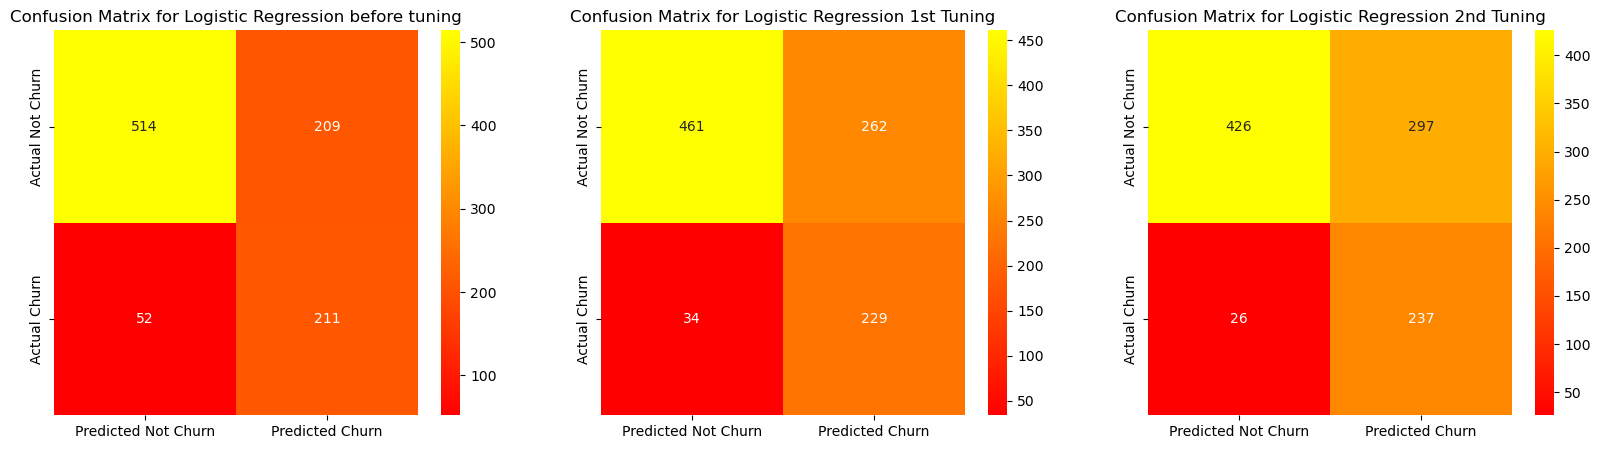

In [75]:
# Get the confusion matrix for before tuning, 1st tuning, and 2nd tuning
before = conf_matrix[3]
tuned = confusion_matrix(y_test, y_pred_tuned)
tuned2 = confusion_matrix(y_test, y_pred_tuned2)

logreg_models = ['Logistic Regression before tuning', 'Logistic Regression 1st Tuning', 'Logistic Regression 2nd Tuning']
logreg_conf_matrices =[before, tuned, tuned2]

# Display confusion matrix
fig, axes = plt.subplots(1, 3, figsize=(20, 5))  # subplot with 1 row and 3 columns
for i, (model, matrix) in enumerate(zip(logreg_models, logreg_conf_matrices)):
    sns.heatmap(logreg_conf_matrices[i], annot=True, fmt='d', cmap='autumn',
                xticklabels=['Predicted Not Churn', 'Predicted Churn'],
                yticklabels=['Actual Not Churn', 'Actual Churn'], ax=axes[i])
    axes[i].set_title(f"Confusion Matrix for {model}");

From the confusion matrix above, it can be seen that the value of False Negatives (Predicted Not Churn, Actually Churn) has decreased, but the value of False Positives (Predicted Churn, Actually Not Churn) has increased. To determine which model to choose, a calculation of the costs incurred by each model is necessary.

## Best Model based on Churn Cost

**Calculating Customer Retention and Customer Acquisition**

source: https://www.optimove.com/resources/learning-center/customer-acquisition-vs-retention-costs#:~:text=The%20cost%20of%20acquiring%20new,customers%20you%20have%20already%20captured.

Customer retention is the cost of keeping an existing customer purchasing. Customer acquisition is the cost of converting a person into a paying customer. Data shows the retaining existing customers is equally, if not more important than acquiring new customers. **The cost of acquiring new customers is five times higher than the cost of retaining existing customers**.

**Churn Cost Simulation**

Assumption: customer retention cost(CRC) = Rp1000 and customer acqusition cost(CAC) = Rp5,000

- True Negative (TN) = Customers who were predicted not to churn and actually did not churn. No action needed, as these customers are satisfied and retained.
    
    Cost = 0
- True Positive (TP) = Customers who were predicted to churn and actually churned. The company should aim to retain these customers by providing incentives, offers, or discounts, which will result in a retention cost.
    
    Cost = TP x CRC
- False Negative (FN) = Customers who were incorrectly predicted not to churn but actually churned. In this case, the company loses customers that should have been retained. To replace these lost customers, the company may need to incur acquisition costs to attract new customers.
    
    Cost = FN x CAC
- False Positive (FP) = Customers who were incorrectly predicted to churn but did not actually churn. In this case, the company may incur retention costs to try to keep customers who actually have no intention of leaving.
    
    Cost = FP x CRC

**Churn Cost without a ML Model**

Assumption: All the customer will churn

Total Cost = (TN + TP + FN + FP) x CRC = (522 + 210 + 53 + 201) x Rp1,000 = Rp986,000

**Churn Cost with ML Model**

Total Cost = (TP x CRC) + (FN x CAC) + (FP x CRC)

Apply to all the Logistic Regression model:
1. Before tuning

    Total Cost = (210 x Rp1,000) + (53 x Rp5,000) + (201 x Rp1,000) = Rp676,000
2. After 1st Tuning

    Total Cost = (231 x Rp1,000) + (32 x Rp5,000) + (266 x Rp1,000) = Rp657,000
3. After 2nd Tuning

    Total Cost = (235 x Rp1,000) + (28 x Rp5,000) + (286 x Rp1,000) = Rp661,000

Based on the calculations above, it was found that Logistic Regression with the **1st hyperparameter tuning** is the most effective model, with the lowest total churn cost of Rp657,000. The trade-off between False Negatives (FN) and False Positives (FP) is a classic challenge in machine learning modeling. In this case, reducing retention costs by lowering FN (which is more costly at Rp5,000) is a priority. Although the 2nd hyperparameter tuning has a better recall of 89%, the 1st hyperparameter tuning is superior in terms of total cost.

**Percentage of churn cost saved**

((Rp986,000 - Rp657,000)/Rp986,000) x 100% = 33.37%

So, in conclusion, the **final model has reduced the churn cost by 33%**.

In [76]:
# Precision-Recall Curve for the best model

best_model = logreg_tuning

# predict probabilities
y_pred_proba = best_model.predict_proba(X_test)

# keep probabilities for the positive outcome only
y_pred_proba = y_pred_proba[:, 1]

# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

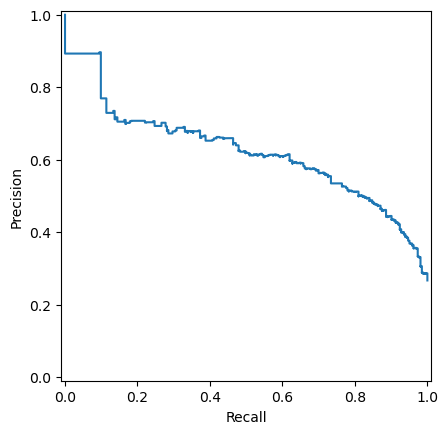

In [77]:
PrecisionRecallDisplay(precision, recall).plot()

---
# Feature Importances

We will see the most important feature in our final model, Logistic Regression with SMOTEEN 1st Hyperparameter Tuning

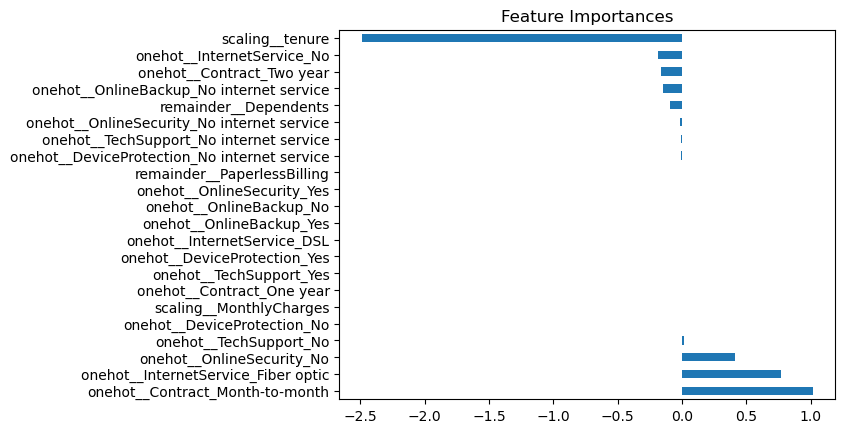

In [78]:
coef1 = pd.Series(best_model['model'].coef_[0], transformer.get_feature_names_out()).sort_values(ascending = False)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

It can be seen from the model above that the feature scaling_tenure is the most important in negative influence, followed by onehot_OnlineSecurity_No internet service, onehot_Contract_Two year, and remainder_Dependents in negative influence. In positive influence, the most important feature is 
onehot_Contract_Month-to-month, followed by onehot_InternetService_Fiber optic, and onehot_OnlineSecurity_No.

---
# Conclusion and Recommendation

In [79]:
report = classification_report(y_test, y_pred_tuned)
print('Classification Report Logistic Regression 1st Tuning: \n', report)

Classification Report Logistic Regression 1st Tuning: 
               precision    recall  f1-score   support

           0       0.93      0.64      0.76       723
           1       0.47      0.87      0.61       263

    accuracy                           0.70       986
   macro avg       0.70      0.75      0.68       986
weighted avg       0.81      0.70      0.72       986



**Conclusion**

Through various machine learning techniques and hyperparameter iterations conducted to predict customer churn, the Logistic Regression model with initial hyperparameter tuning emerged as the most cost-effective solution. By utilizing this model, customer churn costs can be reduced by up to 33% compared to the assumption that all customers are considered to churn. Based on the classification report above, it can be concluded that the Logistic Regression model used is capable of reducing the number of customers likely to churn by 87% (based on its recall results).

**Recommendation**

Here are some recommendations based on feature importance:

1. **Focus on Key Features**: Prioritize features that have shown significant importance in predicting churn, such as Contract type, Monthly Charges, and whether customers have Online Security or not.

2. **Enhance Customer Retention Strategies**:
    - **For customers with a short tenure**: Implement targeted retention strategies for customers with low tenure, as they are more likely to churn. Consider offering incentives for longer commitments or discounts for early renewals.
    - **For customers on month-to-month contracts**: Encourage these customers to switch to longer-term contracts by highlighting the benefits, such as lower monthly rates or additional services.

3. **Improve Service Offerings**:
    - **Address Online Security Concerns**: Since the absence of online security is a significant negative influence, consider enhancing security features or offering bundled services that include online security to increase customer satisfaction and retention.
    - **Evaluate Internet Service Options**: For customers using Fiber optic services, assess the pricing and service quality to ensure competitiveness, as this feature has a notable impact on churn.

4. **Monitor Customer Feedback**: Regularly gather feedback from customers regarding their experiences with services like Tech Support and Device Protection. Use this information to make necessary improvements and address any issues that may lead to churn.

5. **Targeted Marketing Campaigns**:Develop marketing campaigns that specifically target customers identified as high-risk based on the features mentioned. Tailor messages to address their concerns and highlight the value of remaining with the service.

By implementing these recommendations, the company can effectively reduce churn rates and improve overall customer satisfaction.

---
# Pickle Deployment

In [80]:
# Saving best model using pickle

import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [82]:
test_data = pd.concat([X_test, y_test], axis = 1)
test_data.to_csv('test_data.csv', index = False)